In [1]:
# cutout cifar100

In [1]:
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dicts = pickle.load(fo, encoding='bytes')
    return dicts

In [3]:
PATH = '/Users/Hyoje/py3.5/datasets'

ROW, COL = 32, 32
DEPTH = 3
NUM_CLASSES = 100

trX = np.array([]).reshape([0, ROW*COL*DEPTH])
trY = np.array([])
dicts = unpickle(os.path.join(PATH, 'cifar100/train'))
trX = np.concatenate((trX, dicts[b'data'])).astype(np.float32)
# coarse_labels (20 classes) or fine_labels (100 classes)
trY = np.concatenate((trY, dicts[b'fine_labels'])).astype(np.int64)

trX = np.reshape(trX, [len(trX), DEPTH, ROW, COL]).transpose([0, 2, 3, 1])

dicts = unpickle(os.path.join(PATH, 'cifar100/test'))
teX = dicts[b'data'].astype(np.float32)
teY = np.array(dicts[b'fine_labels'], dtype=np.int64)
teX = np.reshape(teX, [len(teX), DEPTH, ROW, COL]).transpose([0, 2, 3, 1])
trX /= 255
teX /= 255

[43 35 85 55]
[ 7 57 40 85]
[19 53 98 61]
[22 39 39 85]


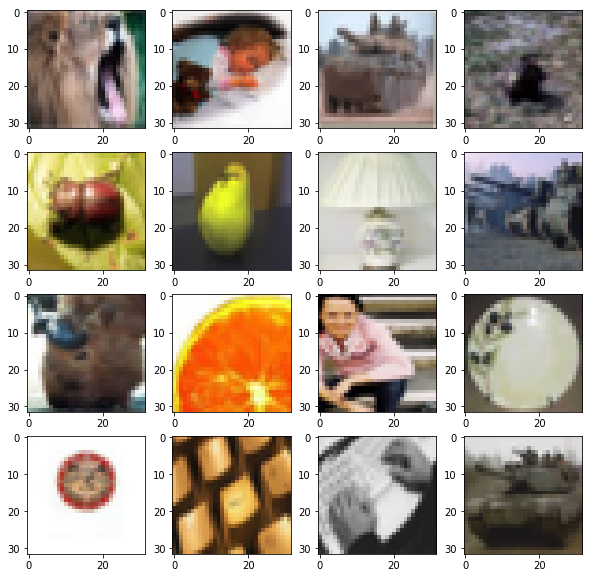

In [4]:
want_num = 4
fig, ax = plt.subplots(nrows=want_num, ncols=want_num, figsize = (10, 10))
check = 2200
for i in range(want_num):
    for j in range(want_num):
        ax[i][j].imshow(trX[want_num*i+j + check])

    print(trY[want_num*i + check : want_num*(i+1) + check])
        
plt.show()

[51  7 99 13]
[25 66 80 22]
[73 83 14 42]
[86 22 90 74]


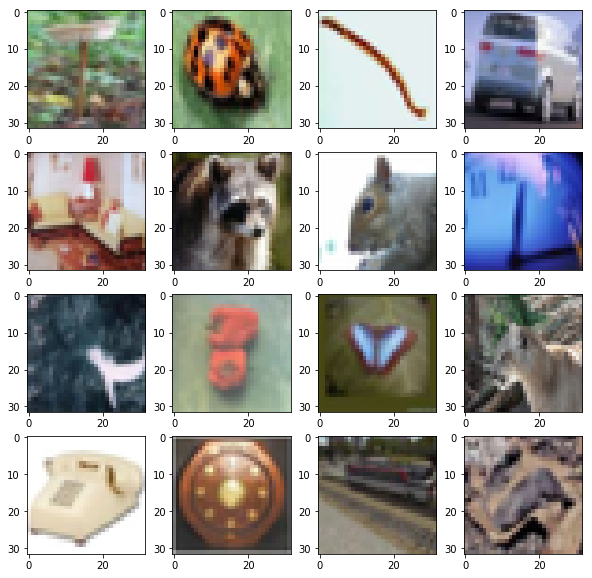

In [5]:
want_num = 4
fig, ax = plt.subplots(nrows=want_num, ncols=want_num, figsize = (10, 10))
check = 2200
for i in range(want_num):
    for j in range(want_num):
        ax[i][j].imshow(teX[want_num*i+j + check])

    print(teY[want_num*i + check : want_num*(i+1) + check])
        
plt.show()

In [6]:
def batch_norm(inputs, momentum=0.9, epsilon=1e-5, scale=True, is_training=True, name='batch_norm'):
    return tf.contrib.layers.batch_norm(inputs=inputs, decay=momentum, 
                                        epsilon=epsilon, scale=scale, 
                                        is_training=is_training, 
                                        updates_collections=None, scope=name)

def conv2d(inputs, filters, k_size, reg=False, padding='same', activation=None, strides=1, name='conv'):
    if reg:
        return tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=k_size, 
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01),
                                strides=strides, padding=padding, 
                                activation=activation, name=name)
    else:
        return tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=k_size, 
                                strides=strides, padding=padding, 
                                activation=activation, name=name)
    
def maxpool(inputs, k_size=2, padding='same', strides=2, name='pooling'):
    return tf.layers.max_pooling2d(inputs=inputs, pool_size=k_size, 
                                   padding=padding, strides=strides, name=name)

In [7]:
def block(inputs, filters, training=True, block_num=0, is_bn=True):
    if is_bn:
        h = conv2d(inputs, filters=filters, k_size=3, activation=None, name='h{}'.format(block_num))
        h_bn = batch_norm(h, is_training=training, name='h{}_bn'.format(block_num))
        h_act = tf.nn.relu(h_bn, name='h{}_act'.format(block_num))
        m = maxpool(h_act, name='h{}_pool'.format(block_num))
    else:
        h = conv2d(inputs, filters=filters, k_size=3, activation=tf.nn.relu, name='h{}'.format(block_num))
        m = maxpool(h, name='h{}_pool'.format(block_num))
    return m

In [8]:
def get_accuracy(sess, logits, img, label, batch_size):    
    if len(img) < batch_size:
        logit = sess.run(logits, feed_dict={X: img, training: False})
    else:
        total_batch = np.ceil((len(img) / batch_size)).astype(np.int32)
        num_classes = int(logits.shape[-1])
        logit = np.array([], dtype=np.int64).reshape(0, num_classes)
        idxs = range(len(img))
        for i in range(total_batch):
            idxs_i = idxs[i * batch_size : (i + 1) * batch_size]
            feed_dict = {X: img[idxs_i], training: False}
            logit = np.concatenate((logit, sess.run(logits, feed_dict=feed_dict)), axis=0)

    correct_pred = np.equal(np.argmax(logit, 1), label).astype(np.float32)
    accuracy = np.mean(correct_pred)
    
    return accuracy, logit, correct_pred

In [9]:
MODEL = 'batch_normal'

X = tf.placeholder(tf.float32, [None, ROW, COL, DEPTH], name='input')
Y = tf.placeholder(tf.int64, [None], name='label')
training = tf.placeholder(tf.bool, name='is_training')


bl0 = block(inputs=X, filters=32, training=training, block_num=0)
bl1 = block(inputs=bl0, filters=64, training=training, block_num=1)
bl2 = block(inputs=bl1, filters=128, training=training, block_num=2)
bl3 = block(inputs=bl2, filters=256, training=training, block_num=3)

output = bl3

flat = tf.reshape(output, [-1, int(np.prod(output.shape[1:]))])
dense1 = tf.layers.dense(flat, units=128, activation=None, name='dense1')
dense1_bn = batch_norm(dense1, is_training=training, name='dense1_bn')
act1 = tf.nn.relu(dense1_bn, name='dense1_act')
logits = tf.layers.dense(act1, units=NUM_CLASSES, activation=None, name='dense2')

C:\Users\Hyoje\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
output

<tf.Tensor 'h3_pool/MaxPool:0' shape=(?, 2, 2, 256) dtype=float32>

In [11]:
tf.trainable_variables()

[<tf.Variable 'h0/kernel:0' shape=(3, 3, 3, 32) dtype=float32_ref>,
 <tf.Variable 'h0/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'h0_bn/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'h0_bn/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'h1/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'h1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'h1_bn/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'h1_bn/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'h2/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'h2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'h2_bn/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'h2_bn/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'h3/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'h3/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'h3_bn/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'h3_bn/gamma:0' shape=(256,) dtype=float3

In [12]:
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [17]:
# hyper prameter
BATCH_SIZE = 128
EPOCHS = 100
CHECK_POINT_DIR = './save_{}'.format(MODEL)
IS_SAVE = False
CUTOUT_SIZE = 8

In [18]:
config=tf.ConfigProto(allow_soft_placement=True)
#config.gpu_options.allocator_type='BFC'
config.log_device_placement=False
config.gpu_options.allow_growth=True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [19]:
# Restore and Save
if IS_SAVE:
    saver = tf.train.Saver()
    checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)

    if checkpoint and checkpoint.model_checkpoint_path:
        try:
            saver.restore(sess, checkpoint.model_checkpoint_path)
            print("Successfully loaded:", checkpoint.model_checkpoint_path)
        except:
            print("Error on loading old network weights")
    else:
        print("Could not find old network weights")
else:
    print('Do not save')

Do not save


In [20]:
class Cutout(object):
    def __init__(self, length, n_hole):
        self.length = length
        self.n_hole = n_hole
        
    def act(self, img):
        N, h, w = img.shape[:-1]
        mask = np.ones([N, h, w], np.float32)
        
        for i in range(self.n_hole):
            for idx in range(N):
                
                y = np.random.randint(h)
                x = np.random.randint(w)

                y1 = np.clip(y - self.length / 2, a_min=0, a_max=h).astype('int32')
                y2 = np.clip(y + self.length / 2, a_min=0, a_max=h).astype('int32')
                x1 = np.clip(x - self.length / 2, a_min=0, a_max=w).astype('int32')
                x2 = np.clip(x + self.length / 2, a_min=0, a_max=w).astype('int32')

                mask[idx, y1:y2, x1:x2] = 0
                
        mask = np.tile(np.expand_dims(mask, axis=-1), reps=3)

        img_cutout = img*mask
        
        return img_cutout

In [21]:
cutout = Cutout(length=CUTOUT_SIZE, n_hole=1)

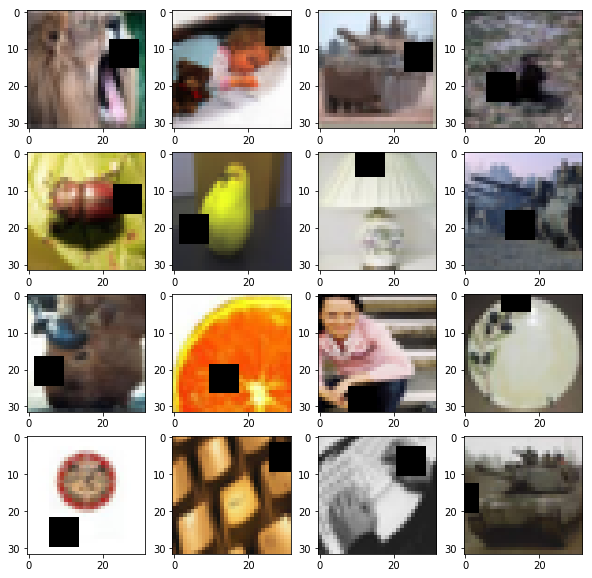

In [22]:
# check output of cutout
want_num = 4
fig, ax = plt.subplots(nrows=want_num, ncols=want_num, figsize = (10, 10))
check = 2200
check_img = trX[check : check + want_num*want_num]
check_img = cutout.act(check_img)
for i in range(want_num):
    for j in range(want_num):
        ax[i][j].imshow(check_img[want_num*i+j])
    
plt.show()

In [23]:
# standardization

for i in range(trX.shape[-1]):
    cal_img = trX[:, :, :, i]
    trX[:, :, :, i] = (cal_img - cal_img.mean()) / (cal_img.std() + 1e-7)
    cal_img = teX[:, :, :, i]
    teX[:, :, :, i] = (cal_img - cal_img.mean()) / (cal_img.std() + 1e-7)

In [24]:
# train - cutout

print(time.asctime())
print('Batch size : {}, Epochs : {}, Save_dir : {}'.format(BATCH_SIZE, EPOCHS, CHECK_POINT_DIR))
print('Learning Started.')

total_start = time.time()
max_accuracy = 0.0
for epoch in range(EPOCHS):
    epoch_start = time.time()
    avg_cost = 0
    total_batch = np.ceil(trX.shape[0] / BATCH_SIZE).astype(np.int32)
    
    # cutout
    trX_cutout = cutout.act(trX)
    
    idxs = np.random.permutation(range(len(trX)))
    for i in range(total_batch):
        idxs_i = idxs[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
        feed_dict = {X: trX_cutout[idxs_i], Y: trY[idxs_i], training: True }    
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    print('=====================================')
    print('Epoch : {:02d} , Cost : {:.5f}'.format(epoch + 1, avg_cost))
    train_accuracy, _, _ = get_accuracy(sess, logits, trX_cutout, trY, BATCH_SIZE)
    print('Train Accuracy : {:.5f}'.format(train_accuracy))
    test_accuracy, _, _ = get_accuracy(sess, logits, teX, teY, BATCH_SIZE)
    print('Test Accuracy : {:.5f}'.format(test_accuracy))
    print('Elapsed time of an epoch: {:.5f}'.format(time.time() - epoch_start))
    if test_accuracy > max_accuracy:
        max_accuracy = test_accuracy
        print('===========Best accuracy=============')
        print(time.asctime())
        print('Best Accuracy : {:.5f}'.format(max_accuracy))
        print('Elapsed time to get the best accuracy: {:.5f}'.format(time.time() - total_start))
        if IS_SAVE:
            print('===========Saving network with the best accuracy===========')
            if not os.path.exists(CHECK_POINT_DIR):
                os.makedirs(CHECK_POINT_DIR)
            saver.save(sess, CHECK_POINT_DIR + "/model", global_step=epoch+1)

print('=====================================')

print('Final Test Accuracy : {:.5f}'.format(max_accuracy))
print('Total elapsed time: {:.5f}'.format(time.time() - total_start))

Sat May 26 17:31:50 2018
Batch size : 128, Epochs : 100, Save_dir : ./save_batch_normal
Learning Started.
Epoch : 01 , Cost : 3.35328
Train Accuracy : 0.32800
Test Accuracy : 0.31160
Elapsed time of an epoch: 66.39349
===========Best accuracy=============
Sat May 26 17:32:57 2018
Best Accuracy : 0.31160
Elapsed time to get the best accuracy: 66.39349
Epoch : 02 , Cost : 2.46887
Train Accuracy : 0.43328
Test Accuracy : 0.39460
Elapsed time of an epoch: 61.02583
===========Best accuracy=============
Sat May 26 17:33:58 2018
Best Accuracy : 0.39460
Elapsed time to get the best accuracy: 127.41932
Epoch : 03 , Cost : 2.11202
Train Accuracy : 0.49742
Test Accuracy : 0.42640
Elapsed time of an epoch: 67.46461
===========Best accuracy=============
Sat May 26 17:35:05 2018
Best Accuracy : 0.42640
Elapsed time to get the best accuracy: 194.88493
Epoch : 04 , Cost : 1.85414
Train Accuracy : 0.52524
Test Accuracy : 0.43610
Elapsed time of an epoch: 77.12578
===========Best accuracy=============
S

Epoch : 47 , Cost : 0.16299
Train Accuracy : 0.97188
Test Accuracy : 0.48700
Elapsed time of an epoch: 132.31828
Epoch : 48 , Cost : 0.15712
Train Accuracy : 0.97540
Test Accuracy : 0.48640
Elapsed time of an epoch: 131.98961
Epoch : 49 , Cost : 0.14940
Train Accuracy : 0.98166
Test Accuracy : 0.49340
Elapsed time of an epoch: 130.12409
Epoch : 50 , Cost : 0.15553
Train Accuracy : 0.98090
Test Accuracy : 0.48980
Elapsed time of an epoch: 129.44190
Epoch : 51 , Cost : 0.14865
Train Accuracy : 0.97768
Test Accuracy : 0.48040
Elapsed time of an epoch: 128.86846
Epoch : 52 , Cost : 0.15050
Train Accuracy : 0.97848
Test Accuracy : 0.48870
Elapsed time of an epoch: 128.77721
Epoch : 53 , Cost : 0.15176
Train Accuracy : 0.98112
Test Accuracy : 0.48910
Elapsed time of an epoch: 129.48286
Epoch : 54 , Cost : 0.13499
Train Accuracy : 0.98084
Test Accuracy : 0.49020
Elapsed time of an epoch: 129.31434
Epoch : 55 , Cost : 0.14689
Train Accuracy : 0.97956
Test Accuracy : 0.49360
Elapsed time of an 

KeyboardInterrupt: 

In [25]:
print('Final Test Accuracy : {:.5f}'.format(max_accuracy))

Final Test Accuracy : 0.49620


In [26]:
# without cutout
# Final Test Accuracy : 0.45950